[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

GROQ_API_KEY:  ········


We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY:  ········


## Messages as state

First, let's define some messages.

In [10]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching Reichenbach's cosmological argument?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know the gist of it. But what specifics should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching Reichenbach's cosmological argument?
================================ Human Message =================================
Name: Lance

Yes, I know the gist of it. But what specifics should I learn about?


Recall we can pass them to a chat model.

In [11]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="llama-3.3-70b-versatile")
llm.invoke(messages)

AIMessage(content='Reichenbach\'s cosmological argument is a version of the cosmological argument, which attempts to prove the existence of God based on the existence of the universe. Here are some key specifics you may want to learn about:\n\n1. **The argument\'s structure**: Reichenbach\'s argument is often formulated as follows:\n\t* Whatever begins to exist has a cause.\n\t* The universe began to exist.\n\t* Therefore, the universe has a cause.\n\t* This cause is God.\n2. **The concept of "beginning to exist"**: Reichenbach\'s argument relies on the idea that the universe had a beginning, often referred to as the "Big Bang." You may want to explore the scientific evidence for this event and its implications for cosmology.\n3. **The cosmological principle**: Reichenbach\'s argument also relies on the cosmological principle, which states that the universe is homogeneous and isotropic on large scales. This principle is supported by a wide range of observational evidence, including the

We can run our chat model in a simple graph with `MessagesState`.

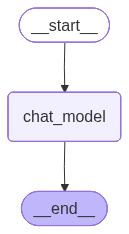

In [12]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching Reichenbach's cosmological argument?
================================ Human Message =================================
Name: Lance

Yes, I know the gist of it. But what specifics should I learn about?
================================== Ai Message ==================================

Reichenbach's cosmological argument is a version of the kalam cosmological argument, which attempts to prove the existence of God based on the concept of causality and the origin of the universe. To delve deeper, you may want to explore the following specifics:

1. **The concept of a "beginning"**: Reichenbach argues that the universe had a beginning, and this beginning requires a cause. You can examine the philosophical and scientific implications of this concept, including the Big Bang theory and the notion of time itself.
2. **The cosmological argument's premises**: Reichenbach's arg

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

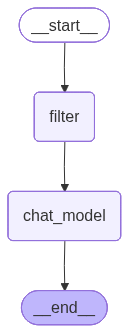

In [14]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Teach me philosophy.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching logical fallacies?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whataboutism. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching logical fallacies?
================================ Human Message =================================
Name: Lance

Yes, I know about whataboutism. But what others should I learn about?
================================== Ai Message ==================================

Whataboutism is a great one to be aware of. Here are some other common logical fallacies you might find useful to learn about:

1. **Ad Hominem**: Attacking the person making an argument, rather than addressing the argument itself.
2. **Strawman**: Misrepresenting or exaggerating someone's argument to make it easier to attack.
3. **False Dichotomy**: Presenting only two options as if they are the only possibilities, when in fact there are other alternatives.
4. **Slippery Slope**: Arguing that a particular action will inevitably lead to a series of negative consequences, without providing evidence for t

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

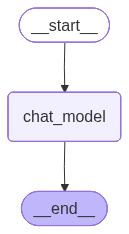

In [16]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [17]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about fallacies!", name="Lance"))

In [18]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Teach me philosophy.
================================== Ai Message ==================================
Name: Bot

So you said you were researching logical fallacies?
================================ Human Message =================================
Name: Lance

Yes, I know about whataboutism. But what others should I learn about?
================================== Ai Message ==================================

Whataboutism is a great one to be aware of. Here are some other common logical fallacies you might find useful to learn about:

1. **Ad Hominem**: Attacking the person making an argument, rather than addressing the argument itself.
2. **Strawman**: Misrepresenting or exaggerating someone's argument to make it easier to attack.
3. **False Dichotomy**: Presenting only two options as if they are the

In [19]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Teach me philosophy.
================================== Ai Message ==================================
Name: Bot

So you said you were researching logical fallacies?
================================ Human Message =================================
Name: Lance

Yes, I know about whataboutism. But what others should I learn about?
================================== Ai Message ==================================

Whataboutism is a great one to be aware of. Here are some other common logical fallacies you might find useful to learn about:

1. **Ad Hominem**: Attacking the person making an argument, rather than addressing the argument itself.
2. **Strawman**: Misrepresenting or exaggerating someone's argument to make it easier to attack.
3. **False Dichotomy**: Presenting only two options as if they are the

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

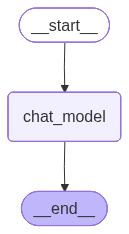

In [20]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatGroq(model="llama-3.3-70b-versatile"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me about Kantian philosophy", name="Lance"))

In [22]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatGroq(model="llama-3.3-70b-versatile"),
            allow_partial=False
        )

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

C:\Users\DELL\Desktop\Jupyter\mat\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\DELL\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

[HumanMessage(content='Tell me about Kantian philosophy', additional_kwargs={}, response_metadata={}, name='Lance')]

In [23]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r